Dataset source: https://mcfp.felk.cvut.cz/publicDatasets/CTU-Malware-Capture-Botnet-42/

# Botnet Detection

# Loading Depenecies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
from scipy import stats
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Dataset

In [3]:
dataset = pd.read_csv(r'.\Dataset\Dataset1.binetflow.2format')
#dataset = dataset[dataset['Label'].str.contains('Botnet')] #Getting the botnet data
print('Rows:',dataset.shape[0], 'Columns:', dataset.shape[1])
dataset = dataset.dropna()
dataset = dataset.loc[:, dataset.isnull().mean() < 0.5]  

#dataset = dataset.loc[:, dataset.dropna().mean() < 0.3]  

Rows: 2824636 Columns: 33


# Feature engineering

In [4]:
dataset = dataset.astype({"Proto":'category',"Sport":'category',"Dport":'category',"State":'category','StartTime':'datetime64[s]','LastTime':'datetime64[s]'}) # Changing the datatype of the columns
dataset['duration'] = abs(dataset['LastTime'].dt.second - dataset['StartTime'].dt.second) # getting duration from the columns 'LastTime' and 'StartTime'
dataset.drop(columns=['SrcAddr','DstAddr','LastTime','StartTime', 'Proto', 'State','Sport','Dport','sTos','dTos'],inplace=True)
#dataset.drop(columns=['Label'],inplace=True)

In [5]:
dataset.loc[dataset['Label'].str.contains('Botnet'), "Label"] = '1'
dataset.loc[dataset['Label'].str.contains('flow'), "Label"] = '0'


# Building the model

In [6]:
dataset.shape
dataset.sample(20)

,SrcWin,DstWin,sHops,dHops,sTtl,dTtl,TcpRtt,SynAck,AckDat,SrcPkts,...,DAppBytes,Dur,TotPkts,TotBytes,TotAppByte,Rate,SrcRate,DstRate,Label,duration
285765,2097152.0,0.0,14.0,1.0,114.0,127.0,0.000000,0.000000,0.000000,2,...,0,0.637022,4,252,0,4.709414,1.588706,1.571112,0,1
584282,64584.0,15360.0,2.0,9.0,126.0,55.0,0.008329,0.008044,0.000285,26,...,3230,393.343811,46,10689,7978,0.114404,0.063558,0.048307,0,27
1182061,65000.0,12544.0,2.0,12.0,126.0,52.0,0.024683,0.024440,0.000243,11,...,779,54.652847,22,4509,3225,0.384243,0.182973,0.183056,0,5
1258998,14720.0,5792.0,1.0,10.0,63.0,54.0,0.007067,0.006991,0.000076,4,...,0,16.812607,7,478,0,0.356875,0.178438,0.119008,0,17
2001196,1172736.0,6432.0,1.0,12.0,63.0,244.0,0.001029,0.000874,0.000155,8,...,2124,60.003925,14,3445,2509,0.216652,0.116659,0.083329,0,0
1979902,373760.0,0.0,1.0,22.0,63.0,234.0,0.000000,0.000000,0.000000,1,...,0,0.506884,2,134,0,1.972838,0.000000,0.000000,0,1
2671433,256960.0,5840.0,2.0,8.0,126.0,56.0,0.006885,0.006494,0.000391,4,...,0,10.754793,6,366,0,0.464909,0.278945,0.332015,0,11
544358,65304.0,18624.0,2.0,8.0,126.0,56.0,0.002515,0.001906,0.000609,28,...,26645,8.546429,55,35573,32471,6.318429,3.159214,4.247507,0,8
2174708,65700.0,7680.0,1.0,15.0,127.0,49.0,0.114619,0.113475,0.001144,8,...,9103,21.216309,19,11088,9984,0.848404,0.331709,0.473870,0,39
944191,65169.0,65535.0,1.0,1.0,127.0,63.0,0.000326,0.000159,0.000167,8,...,366,0.052298,15,2209,1349,267.696686,133.848343,115.569077,0,0


Load Train Dataset

In [11]:
x_train, x_test, y_train, y_test = train_test_split(dataset.drop('Label', axis=1), dataset.Label, test_size=0.5)
x_train = np.asarray(x_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(213655, 23)
(213655, 23)
(213655,)
(213655,)


In [14]:
np.isnan(x_train)

AttributeError: module 'numpy' has no attribute 'hasnan'

Algorithm

In [8]:
nb_epoch = 50
input_dim = x_train.shape[1]
learning_rate = 50

model = Sequential()
model.add(Dense(int(0.75 * input_dim), activation="relu", input_dim=input_dim))
model.add(Dense(int(0.5 * input_dim), activation="relu"))
model.add(Dense(int(0.25 * input_dim), activation="relu"))
model.add(Dense(int(0.75 * input_dim), activation="relu"))
model.add(Dense(int(1), activation="sigmoid"))

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','MeanSquaredError'])

save_model = ModelCheckpoint(filepath="Models/Haren_BotDetection_Uni_Test.h20", save_best_only=True, verbose=0)


history = model.fit(x_test, y_test,
                    epochs=nb_epoch,
                    validation_data=(x_train, y_train),
                    batch_size=2000,
                    verbose=1,
                    callbacks=[save_model]).history


Epoch 1/50
107/107 [==============================] - 10s 35ms/step - loss: 537.3604 - accuracy: 0.9135 - mean_squared_error: 0.0864 - val_loss: 15.4046 - val_accuracy: 0.9950 - val_mean_squared_error: 0.0050
Epoch 2/50
107/107 [==============================] - 1s 13ms/step - loss: 15.1029 - accuracy: 0.9911 - mean_squared_error: 0.0088 - val_loss: 13.1154 - val_accuracy: 0.9881 - val_mean_squared_error: 0.0116
Epoch 3/50
107/107 [==============================] - 1s 14ms/step - loss: 13.1739 - accuracy: 0.9890 - mean_squared_error: 0.0107 - val_loss: 11.4097 - val_accuracy: 0.9906 - val_mean_squared_error: 0.0092
Epoch 4/50
107/107 [==============================] - 4s 41ms/step - loss: 11.1921 - accuracy: 0.9901 - mean_squared_error: 0.0096 - val_loss: 9.4207 - val_accuracy: 0.9910 - val_mean_squared_error: 0.0087
Epoch 5/50
107/107 [==============================] - 2s 15ms/step - loss: 8.8647 - accuracy: 0.9913 - mean_squared_error: 0.0083 - val_loss: 7.0021 - val_accuracy: 0.9877

TypeError: Expected sequence or array-like, got <class 'keras.engine.sequential.Sequential'>

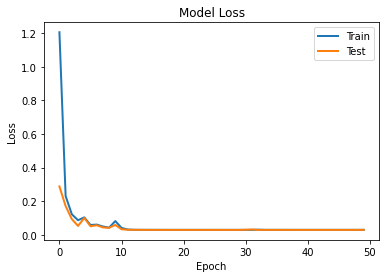

In [34]:
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

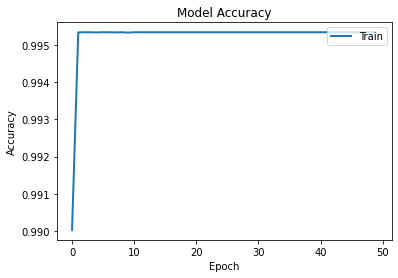

In [35]:
plt.plot(history['accuracy'], linewidth=2, label='Train')
#plt.plot(history['val_accuracy'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

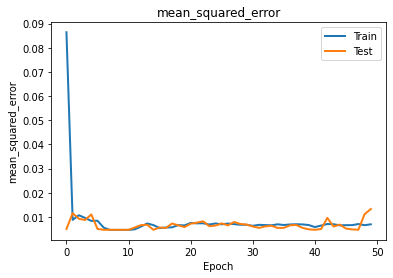

In [10]:
plt.plot(history['mean_squared_error'], linewidth=2, label='Train')
plt.plot(history['val_mean_squared_error'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('Epoch')
plt.show()

## 